##### For the used car price regression problem, two versions of data preprocessing and model implementation were used. In version 1, missing values in categorical columns were replaced by a new category labeled 'Unknown'. Features were then derived from the 'engine' categorical column, while other categorical columns were retained without modification. Since CatBoost natively supports categorical features, the preprocessed data was directly used to train the model. Ensemble methods, such as bagging, majority voting, and stacking, were applied using CatBoost as the base learner. 

##### Among all the techniques, the bagging with catboost gave best result in private score RMS = 63418.57. However, since kaggle selected best two submission from public score, the majority voting is taken as best performer with private score RMS = 63453.05 and public score 72533.54. 

##### In version 2, missing values were handled by replacing them with the most common value (mode). Label Encoding was applied to all categorical columns to convert them into numerical values. Since the 'clean_title' column contained only a single value, 'yes', it was removed. After preprocessing, ten different models were tested with various hyperparameters, including Random Forest, HistGradientBoostingRegressor, XGBoost, Gradient Boosting, CatBoost, Bagging, Majority Voting, Stacking, and a simple Neural Network. Among these, CatBoost achieved the best RMS score of 75514.86 on the public leaderboard. However, on the private leaderboard, it did not outperform Version 1, achieving an RMS score of 63587.32. 

##### Most of the other works have used LGBM and CatBoost. I experimented with nine different models to identify the best-performing one. However, the issue was inefficient feature engineering, which prevented the model from achieving a higher rank on the Kaggle leaderboard.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# Version 1

## Loading Data

In [8]:
import pandas as pd
import numpy as np 

df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


## Missing Value Handling

In [9]:
# NaN values in `clean_title` replaced with a new category 'Unknown'

df_train['clean_title'] = df_train['clean_title'].fillna('Unknown')
df_test['clean_title'] = df_test['clean_title'].fillna('Unknown')

In [10]:
# NaN values in `accident` replaced with a new category 'Unknown'

df_train['accident'] = df_train['accident'].fillna('Unknown')
df_test['accident'] = df_test['accident'].fillna('Unknown')

In [11]:
#`nan`, `–`, and `not supported` are replaced with 'Unknown'
df_train['fuel_type'] = df_train['fuel_type'].replace(['–', 'not supported', np.nan], 'Unknown')
df_test['fuel_type'] = df_test['fuel_type'].replace(['–', 'not supported', np.nan], 'Unknown')


In [12]:
# Check if there is any null element
null_element = df_train.isnull().sum()
null_element

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [13]:
# Extract features from engine categorical column

import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder


# Function to extract engine details
def extract_engine_features(engine_desc):
    # Extract horsepower
    hp_match = re.search(r'(\d+\.\d+|\d+)HP', engine_desc)
    horsepower = float(hp_match.group(1)) if hp_match else 0

    # Extract engine size
    size_match = re.search(r'(\d+\.\d+|\d+)L', engine_desc)
    engine_size = float(size_match.group(1)) if size_match else 0

    # Extract number of cylinders
    cyl_match = re.search(r'(\d+) Cylinder', engine_desc)
    num_cylinders = int(cyl_match.group(1)) if cyl_match else 0

    # Extract fuel type
    fuel_match = re.search(r'Engine (.+?) Fuel', engine_desc)
    fuel_type = fuel_match.group(1) if fuel_match else 'Unknown'

    return horsepower, engine_size, num_cylinders, fuel_type

# Apply extraction function to engine column
df_train[['horsepower', 'engine_size', 'num_cylinders', 'fuel_type_engine']] = df_train['engine'].apply(
    lambda x: pd.Series(extract_engine_features(x)))

df_test[['horsepower', 'engine_size', 'num_cylinders', 'fuel_type_engine']] = df_test['engine'].apply(
    lambda x: pd.Series(extract_engine_features(x)))

# Check the extracted features
print("Sample extracted engine features (Train):\n", df_train[['horsepower', 'engine_size', 'num_cylinders', 'fuel_type_engine']].head())

# Encode `fuel_type_engine` using Label Encoding
le = LabelEncoder()
df_train['fuel_type_engine'] = le.fit_transform(df_train['fuel_type_engine'])
df_test['fuel_type_engine'] = le.transform(df_test['fuel_type_engine'])

# Drop the original `engine` column 
df_train.drop('engine', axis=1, inplace=True)
df_test.drop('engine', axis=1, inplace=True)

# Check the final DataFrame
print("Train DataFrame after processing `engine`:\n", df_train.head())
print("Test DataFrame after processing `engine`:\n", df_test.head())


Sample extracted engine features (Train):
    horsepower  engine_size  num_cylinders fuel_type_engine
0       172.0          1.6              4         Gasoline
1       252.0          3.9              8         Gasoline
2       320.0          5.3              8             Flex
3       420.0          5.0              8         Gasoline
4       208.0          2.0              4         Gasoline
Train DataFrame after processing `engine`:
    id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                     transmission ext_col int_col  \
0                             A/T  Ye

In [14]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,num_cylinders,fuel_type_engine
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4,2
1,1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8,2
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8,1
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8,2
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4,2


In [15]:
# Drop the 'id' column in the training and test data

X = df_train.drop(['id', 'price'], axis=1)  
y = df_train['price']  # Target variable (price)

X_test = df_test.drop(['id'], axis=1)

In [16]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = True, stratify = y)

In [17]:
# Select all categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Features: {categorical_features}")
categorical_feature_indices = [X.columns.get_loc(col) for col in categorical_features]

categorical_feature_indices

Categorical Features: ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


[0, 1, 4, 5, 6, 7, 8, 9]

## Model Running (Ensemble Methods)

1. CatBoost Regressor

2. Bagging Catboost

3. Majority Vote

4. Stacking

In [18]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Create the CatBoostRegressor model
model = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth=6, cat_features=categorical_feature_indices, verbose=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the val set
y_pred = model.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

0:	learn: 78881.4497524	total: 204ms	remaining: 5m 5s
100:	learn: 74411.1269642	total: 14.6s	remaining: 3m 21s
200:	learn: 73393.1372373	total: 28.6s	remaining: 3m 4s
300:	learn: 73042.5172114	total: 42.8s	remaining: 2m 50s
400:	learn: 72876.2254251	total: 57.4s	remaining: 2m 37s
500:	learn: 72765.5178749	total: 1m 10s	remaining: 2m 21s
600:	learn: 72683.3537826	total: 1m 24s	remaining: 2m 5s
700:	learn: 72612.6148978	total: 1m 37s	remaining: 1m 51s
800:	learn: 72539.4498048	total: 1m 50s	remaining: 1m 36s
900:	learn: 72469.4446799	total: 2m 4s	remaining: 1m 22s
1000:	learn: 72394.2288419	total: 2m 17s	remaining: 1m 8s
1100:	learn: 72332.2406407	total: 2m 30s	remaining: 54.7s
1200:	learn: 72267.6138329	total: 2m 44s	remaining: 41s
1300:	learn: 72211.8939326	total: 2m 57s	remaining: 27.2s
1400:	learn: 72159.6551157	total: 3m 11s	remaining: 13.5s
1499:	learn: 72108.2266638	total: 3m 23s	remaining: 0us
Root Mean Squared Error: 72163.71887858966


In [19]:
# Make predictions on the test data

y_test_pred = model.predict(X_test)

# Save the results in a submission file for Kaggle submission

submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_cat_model.csv', index=False)

In [20]:
from sklearn.ensemble import BaggingRegressor

# CatBoost with Bagging Regressor
bagging_model = BaggingRegressor(estimator=model, n_estimators=20, random_state=42)

# Train the bagging model
bagging_model.fit(X_train, y_train)

# Make predictions on the val set
y_pred = bagging_model.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

0:	learn: 78518.1114870	total: 130ms	remaining: 3m 15s
100:	learn: 73861.0078096	total: 12.9s	remaining: 2m 58s
200:	learn: 72705.8265149	total: 25.5s	remaining: 2m 44s
300:	learn: 72249.1735795	total: 38.8s	remaining: 2m 34s
400:	learn: 71965.6582809	total: 52.5s	remaining: 2m 23s
500:	learn: 71734.5342914	total: 1m 5s	remaining: 2m 10s
600:	learn: 71591.8830631	total: 1m 19s	remaining: 1m 58s
700:	learn: 71441.5794616	total: 1m 31s	remaining: 1m 44s
800:	learn: 71293.1332654	total: 1m 46s	remaining: 1m 32s
900:	learn: 71153.7409955	total: 1m 59s	remaining: 1m 19s
1000:	learn: 71036.9773296	total: 2m 12s	remaining: 1m 5s
1100:	learn: 70918.6659068	total: 2m 25s	remaining: 52.6s
1200:	learn: 70791.1378096	total: 2m 37s	remaining: 39.3s
1300:	learn: 70679.7809753	total: 2m 51s	remaining: 26.3s
1400:	learn: 70559.5507330	total: 3m 4s	remaining: 13s
1499:	learn: 70444.9076553	total: 3m 16s	remaining: 0us
0:	learn: 74346.6904263	total: 122ms	remaining: 3m 3s
100:	learn: 69890.0877725	total

In [18]:
# Predict on the test set

y_test_pred = bagging_model.predict(X_test)
# Save the results in a submission file for kaggle submission

submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_bagging_cat.csv', index=False)

In [17]:
from sklearn.ensemble import VotingRegressor

# Create a Voting Regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', model),
        ('bagging_catboost', bagging_model),
        ('catboost1', model),
        ('bagging_catboost1', bagging_model),
    ]
)

# Fit the Voting Regressor to the training data
voting_regressor.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_vot = voting_regressor.predict(X_val)

# Calculate RMSE
rmse_vot = mean_squared_error(y_val, y_val_pred_vot, squared=False)
print(f"Validation RMSE (Majority Voting): {rmse_vot}")

0:	learn: 78881.4497524	total: 137ms	remaining: 3m 25s
100:	learn: 74411.1269642	total: 12.9s	remaining: 2m 58s
200:	learn: 73393.1372373	total: 25.3s	remaining: 2m 43s
300:	learn: 73042.5172114	total: 38.5s	remaining: 2m 33s
400:	learn: 72876.2254251	total: 51s	remaining: 2m 19s
500:	learn: 72765.5178749	total: 1m 3s	remaining: 2m 7s
600:	learn: 72683.3537826	total: 1m 15s	remaining: 1m 53s
700:	learn: 72612.6148978	total: 1m 27s	remaining: 1m 40s
800:	learn: 72539.4498048	total: 1m 40s	remaining: 1m 27s
900:	learn: 72469.4446799	total: 1m 51s	remaining: 1m 14s
1000:	learn: 72394.2288419	total: 2m 3s	remaining: 1m 1s
1100:	learn: 72332.2406407	total: 2m 15s	remaining: 49.2s
1200:	learn: 72267.6138329	total: 2m 27s	remaining: 36.7s
1300:	learn: 72211.8939326	total: 2m 39s	remaining: 24.4s
1400:	learn: 72159.6551157	total: 2m 51s	remaining: 12.1s
1499:	learn: 72108.2266638	total: 3m 2s	remaining: 0us


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0:	learn: 78518.1114870	total: 115ms	remaining: 2m 52s
100:	learn: 73861.0078096	total: 11.3s	remaining: 2m 36s
200:	learn: 72705.8265149	total: 22.3s	remaining: 2m 24s
300:	learn: 72249.1735795	total: 33.5s	remaining: 2m 13s
400:	learn: 71965.6582809	total: 45.2s	remaining: 2m 3s
500:	learn: 71734.5342914	total: 56.4s	remaining: 1m 52s
600:	learn: 71591.8830631	total: 1m 7s	remaining: 1m 40s
700:	learn: 71441.5794616	total: 1m 18s	remaining: 1m 29s
800:	learn: 71293.1332654	total: 1m 29s	remaining: 1m 17s
900:	learn: 71153.7409955	total: 1m 40s	remaining: 1m 6s
1000:	learn: 71036.9773296	total: 1m 51s	remaining: 55.5s
1100:	learn: 70918.6659068	total: 2m 2s	remaining: 44.3s
1200:	learn: 70791.1378096	total: 2m 13s	remaining: 33.2s
1300:	learn: 70679.7809753	total: 2m 25s	remaining: 22.2s
1400:	learn: 70559.5507330	total: 2m 36s	remaining: 11s
1499:	learn: 70444.9076553	total: 2m 46s	remaining: 0us
0:	learn: 74346.6904263	total: 142ms	remaining: 3m 33s
100:	learn: 69890.0877725	total: 

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0:	learn: 78518.1114870	total: 107ms	remaining: 2m 40s
100:	learn: 73861.0078096	total: 11.4s	remaining: 2m 38s
200:	learn: 72705.8265149	total: 22.5s	remaining: 2m 25s
300:	learn: 72249.1735795	total: 33.7s	remaining: 2m 14s
400:	learn: 71965.6582809	total: 45.4s	remaining: 2m 4s
500:	learn: 71734.5342914	total: 56.7s	remaining: 1m 53s
600:	learn: 71591.8830631	total: 1m 7s	remaining: 1m 41s
700:	learn: 71441.5794616	total: 1m 18s	remaining: 1m 29s
800:	learn: 71293.1332654	total: 1m 29s	remaining: 1m 18s
900:	learn: 71153.7409955	total: 1m 40s	remaining: 1m 7s
1000:	learn: 71036.9773296	total: 1m 51s	remaining: 55.6s
1100:	learn: 70918.6659068	total: 2m 2s	remaining: 44.4s
1200:	learn: 70791.1378096	total: 2m 14s	remaining: 33.4s
1300:	learn: 70679.7809753	total: 2m 25s	remaining: 22.3s
1400:	learn: 70559.5507330	total: 2m 36s	remaining: 11.1s
1499:	learn: 70444.9076553	total: 2m 47s	remaining: 0us
0:	learn: 74346.6904263	total: 106ms	remaining: 2m 38s
100:	learn: 69890.0877725	total

In [19]:
y_test_pred = voting_regressor.predict(X_test)
# Save the results in a submission file
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_voting_regressor.csv', index=False)

In [21]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import numpy as np

# Define the base models
base_models = [
        ('catboost', model),
        ('bagging_catboost', bagging_model),
        ('catboost1', model),
        ('bagging_catboost1', bagging_model),
]

# Define the meta-model (regressor)
meta_model = Ridge()

# Create the StackingRegressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=3)

# Train the stacking model on the training data
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_val_pred = stacking_regressor.predict(X_val)

# Evaluate the model using RMSE
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

0:	learn: 78881.4497524	total: 145ms	remaining: 3m 37s
100:	learn: 74411.1269642	total: 13.8s	remaining: 3m 10s
200:	learn: 73393.1372373	total: 28.3s	remaining: 3m 2s
300:	learn: 73042.5172114	total: 42.6s	remaining: 2m 49s
400:	learn: 72876.2254251	total: 56.8s	remaining: 2m 35s
500:	learn: 72765.5178749	total: 1m 10s	remaining: 2m 19s
600:	learn: 72683.3537826	total: 1m 23s	remaining: 2m 5s
700:	learn: 72612.6148978	total: 1m 36s	remaining: 1m 50s
800:	learn: 72539.4498048	total: 1m 49s	remaining: 1m 35s
900:	learn: 72469.4446799	total: 2m 2s	remaining: 1m 21s
1000:	learn: 72394.2288419	total: 2m 15s	remaining: 1m 7s
1100:	learn: 72332.2406407	total: 2m 27s	remaining: 53.6s
1200:	learn: 72267.6138329	total: 2m 40s	remaining: 40s
1300:	learn: 72211.8939326	total: 2m 53s	remaining: 26.5s
1400:	learn: 72159.6551157	total: 3m 6s	remaining: 13.2s
1499:	learn: 72108.2266638	total: 3m 18s	remaining: 0us
0:	learn: 78518.1114870	total: 118ms	remaining: 2m 56s
100:	learn: 73861.0078096	total:

# Version 2

## Load Dataset

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


## Missing Value Handling with mode

In [40]:
null_element = df_train.isnull().sum()
null_element

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [3]:
# Get the most common fuel type using mode
most_common_fuel = df_train['fuel_type'].mode()[0]
most_fuel_type = df_test['fuel_type'].mode()[0]

# Fill missing values in 'fuel_type' and reassign back to the DataFrame
df_train['fuel_type'] = df_train['fuel_type'].fillna(most_common_fuel)
df_test['fuel_type'] = df_test['fuel_type'].fillna(most_fuel_type)

print(df_train['fuel_type'].isnull().sum())

0


In [4]:
# Get the most common accident using mode
most_common_accident = df_train['accident'].mode()[0]
most_accident = df_test['accident'].mode()[0]

# Fill missing values in 'accident' and reassign back to the DataFrame
df_train['accident'] = df_train['accident'].fillna(most_common_accident)
df_test['accident'] = df_test['accident'].fillna(most_accident)

In [5]:
# Get the most common clean title using mode
most_common_title = df_train['clean_title'].mode()[0]
most_clean_title = df_test['clean_title'].mode()[0]

# Fill missing values in 'clean_title' and reassign back to the DataFrame
df_train['clean_title'] = df_train['clean_title'].fillna(most_common_title)
df_test['clean_title'] = df_test['clean_title'].fillna(most_clean_title)

In [6]:
null_element = df_train.isnull().sum()
null_element

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [7]:
# Label Encoding to categorical columns 

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# List of all categorical columns
cat_columns = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 
               'int_col', 'accident', 'clean_title']

# Create copies of the original DataFrames to encode
df_train_encode = df_train.copy()
df_test_encode = df_test.copy()

encoders = {}

# Apply Label Encoding to each categorical column in both train and test data
for col in cat_columns:
    encoders[col] = LabelEncoder() 
    
    # Fit and transform on the training set
    df_train_encode[col] = encoders[col].fit_transform(df_train_encode[col].astype(str))  
    
    # Handle unseen categories in the test set
    df_test_encode[col] = df_test_encode[col].astype(str) 
    
    # Map the test data to the training data's categories
    df_test_encode[col] = df_test_encode[col].apply(lambda x: x if x in encoders[col].classes_ else 'unknown')

    # Update the LabelEncoder's classes_ to include 'unknown'
    encoders[col].classes_ = np.append(encoders[col].classes_, 'unknown')
    
    # Transform the test set
    df_test_encode[col] = encoders[col].transform(df_test_encode[col])

# df_train_encode and df_test_encode contain the encoded categorical data
print(df_train_encode.head())
print(df_test_encode.head())

   id  brand  model  model_year  milage  fuel_type  engine  transmission  \
0   0     31    495        2007  213000          2     116            38   
1   1     28    930        2002  143250          2     366            38   
2   2      9   1575        2002  136731          1     640            38   
3   3     16    758        2017   19500          2     863            49   
4   4     36   1077        2021    7388          2     259            23   

   ext_col  int_col  accident  clean_title  price  
0      312       71         1            0   4200  
1      263       10         0            0   4999  
2       38       71         1            0  13900  
3       29       14         1            0  45000  
4       29       10         1            0  97500  
       id  brand  model  model_year  milage  fuel_type  engine  transmission  \
0  188533     26   1390        2015   98000          2     325            16   
1  188534     26   1377        2020    9142          3     787         

In [8]:
# clean title has only one value 'yes', so dropping it
df_train_encode = df_train_encode.drop('clean_title', axis=1)
df_test_encode = df_test_encode.drop('clean_title', axis=1)

# EDA

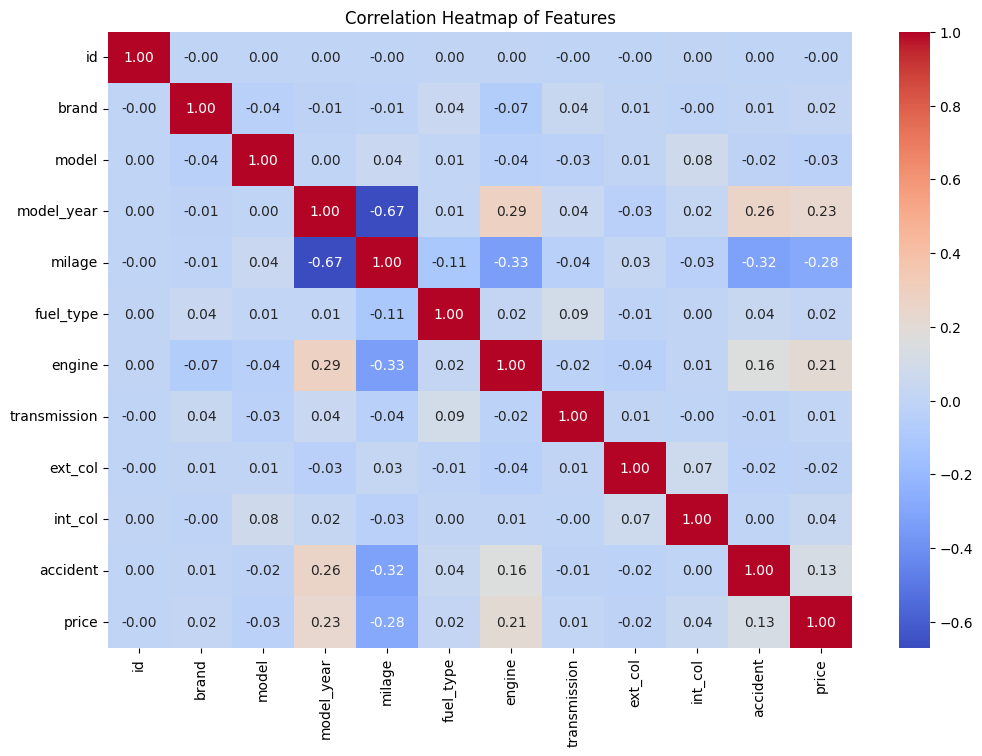

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = df_train_encode.corr()

plt.figure(figsize=(12, 8))

# The heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

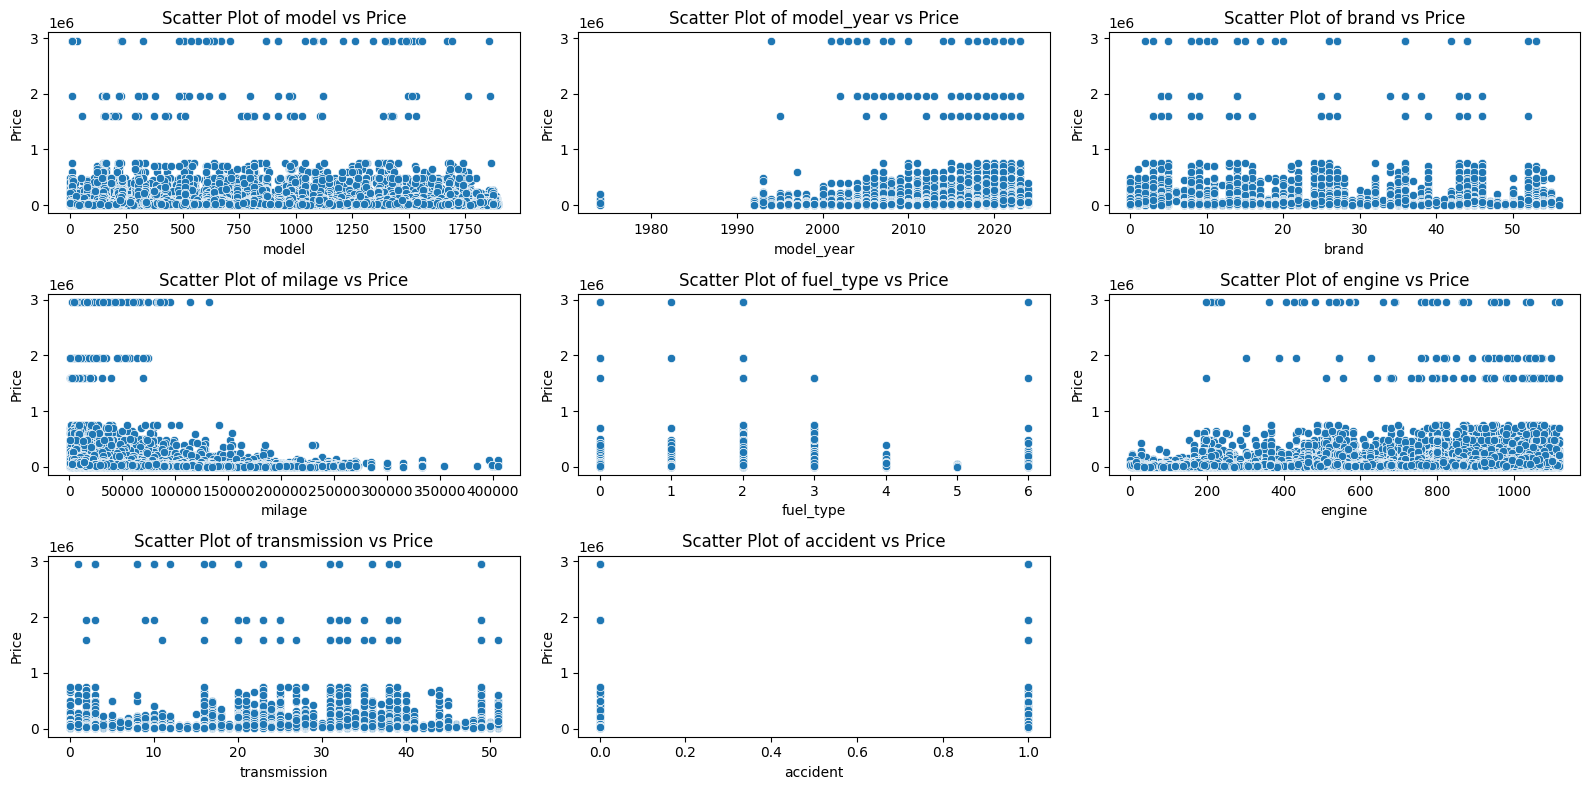

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features 
features_to_plot = ['model','model_year', 'brand', 'milage', 'fuel_type', 'engine', 'transmission', 'accident']

# Create scatter plots for each feature against the target 'price'
plt.figure(figsize=(16, 8))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i) 
    sns.scatterplot(x=df_train_encode[feature], y=df_train['price'])
    plt.title(f'Scatter Plot of {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()


In [9]:
# Drop the 'id' column in the training and test data
X = df_train_encode.drop(['id', 'price'], axis=1)  
y = df_train_encode['price']  # Target variable (price)

X_test = df_test_encode.drop(['id'], axis=1)

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle = True, stratify = y)

In [11]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_val_scaled = x_scaler.transform( X_val)

X_test_scaled = x_scaler.transform( X_test)

In [12]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Model Running

1. Random Forest

2. HistGradientBoostingRegressor

3. XGBoost

4. Gradient Boosting

5. CatBoost

6. Bagging

7. Majority Voting

8. Stacking

9. Simple Neural Network

In [16]:
from sklearn.ensemble import RandomForestRegressor

# RandomForest model
rf = RandomForestRegressor(random_state=42)

# Train the model on the training set
rf.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = rf.predict(X_val_scaled)

# Calculate RMSE for validation set
rmse_val = calculate_rmse(y_val, y_val_pred)
print(f"Validation RMSE: {rmse_val}")

Validation RMSE: 79079.2407932068


In [36]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation 
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Use RMSE as the scoring metric
cv_rmse = (-cv_scores.mean()) ** 0.5
print(f"Cross-Validation RMSE: {cv_rmse}")

Cross-Validation RMSE: 78426.37377424397


In [22]:
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

# HistGradientBoostingRegressor model
hgb_model = HistGradientBoostingRegressor(
    max_iter=500,  
    learning_rate=0.01,  
    max_depth=5,
    random_state=42,
    
)

# Fit the model to the training data
hgb_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = hgb_model.predict(X_val_scaled)

# Calculate the RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 72310.7265519739


In [19]:
import xgboost as xgb

# XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',  n_estimators=500, max_depth=5
                             , learning_rate=0.01, random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_scaled)

# Define RMSE function
def calculate_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Calculate RMSE for validation set
rmse_val = calculate_rmse(y_val, y_val_pred)
print(f"Validation RMSE: {rmse_val}")

Validation RMSE: 72378.6308968073


In [41]:
# Perform cross-validation 
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# RMSE for cross-validation 
cv_rmse = (-cv_scores.mean()) ** 0.5
print(f"Cross-Validation RMSE: {cv_rmse}")

Cross-Validation RMSE: 73115.75434527722


In [42]:
# Predict on the test set
y_test_pred = xgb_model.predict(X_test)

# Save the results in a submission file 
submission = pd.DataFrame({'id': df_test_encode['id'], 'price': y_test_pred})
submission.to_csv('submission_xgb_GS.csv', index=False)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# GBoost regressor
gb_model = GradientBoostingRegressor(n_estimators=500, max_depth=5, 
                                     learning_rate=0.01, random_state=42)

# Train the model
gb_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = gb_model.predict(X_val_scaled)

# Define RMSE function
def calculate_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Calculate RMSE for validation set
rmse_val = calculate_rmse(y_val, y_val_pred)
print(f"Validation RMSE: {rmse_val}")

Validation RMSE: 72396.6690524636


In [20]:
import catboost as cb

# CatBoost Regressor
catboost_model = cb.CatBoostRegressor(
    iterations=2500, 
    learning_rate=0.01,  
    l2_leaf_reg = 15,
    border_count = 128, 
    depth=7,  # Tree depth
    loss_function='RMSE',  
    random_seed=42, 
    verbose=100 
    
)

# Train the model 
catboost_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=100)


0:	learn: 78881.1419445	test: 78259.2216304	best: 78259.2216304 (0)	total: 80.1ms	remaining: 3m 20s
100:	learn: 74574.0411209	test: 73973.1266449	best: 73973.1266449 (100)	total: 2.19s	remaining: 52s
200:	learn: 73606.0512432	test: 73061.3567863	best: 73061.3567863 (200)	total: 3.89s	remaining: 44.5s
300:	learn: 73212.7845363	test: 72749.8963895	best: 72749.8963895 (300)	total: 5.5s	remaining: 40.2s
400:	learn: 72983.4381145	test: 72598.4590806	best: 72598.4590806 (400)	total: 7.07s	remaining: 37s
500:	learn: 72818.8277280	test: 72509.9147083	best: 72509.9147083 (500)	total: 8.65s	remaining: 34.5s
600:	learn: 72675.0025817	test: 72443.2435705	best: 72443.2435705 (600)	total: 10.3s	remaining: 32.4s
700:	learn: 72552.9321392	test: 72397.6632007	best: 72397.6632007 (700)	total: 11.8s	remaining: 30.3s
800:	learn: 72438.1243424	test: 72365.4856370	best: 72365.4856370 (800)	total: 13.4s	remaining: 28.5s
900:	learn: 72331.5471629	test: 72339.5784052	best: 72339.5784052 (900)	total: 15s	remain

In [ ]:
# Predict on the test set
y_test_pred = catboost_model.predict(X_test)

# Save the results in a submission file for kaggle submission
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_catboost_new.csv', index=False)

In [22]:
from sklearn.ensemble import BaggingRegressor

# Bagging with CatBoost
bagging_catboost = BaggingRegressor(estimator=catboost_model, n_estimators=50,bootstrap=True, random_state=42)
bagging_catboost.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred_catboost = bagging_catboost.predict(X_val_scaled)

# Calculate RMSE
rmse_catboost = mean_squared_error(y_val, y_val_pred_catboost, squared=False)
print(f"Validation RMSE (Bagging + CatBoost): {rmse_catboost}")


0:	learn: 78521.5987236	total: 19.4ms	remaining: 48.6s
100:	learn: 74026.9879073	total: 1.55s	remaining: 36.9s
200:	learn: 72940.3382759	total: 3.02s	remaining: 34.5s
300:	learn: 72476.5503644	total: 4.45s	remaining: 32.5s
400:	learn: 72184.7975893	total: 5.86s	remaining: 30.7s
500:	learn: 71934.8871851	total: 7.33s	remaining: 29.3s
600:	learn: 71733.4421457	total: 8.72s	remaining: 27.5s
700:	learn: 71532.6294798	total: 10.1s	remaining: 26s
800:	learn: 71337.1340337	total: 11.5s	remaining: 24.5s
900:	learn: 71172.9654754	total: 12.9s	remaining: 23s
1000:	learn: 70957.5541268	total: 14.3s	remaining: 21.5s
1100:	learn: 70745.1527643	total: 15.7s	remaining: 20s
1200:	learn: 70562.3736984	total: 17.2s	remaining: 18.6s
1300:	learn: 70431.2626799	total: 18.5s	remaining: 17.1s
1400:	learn: 70328.0775600	total: 19.8s	remaining: 15.5s
1500:	learn: 70235.6352636	total: 21.1s	remaining: 14s
1600:	learn: 70132.8159214	total: 22.4s	remaining: 12.6s
1700:	learn: 69951.8588225	total: 23.8s	remaining:

In [23]:
# Predict on the test set
y_test_pred = catboost_model.predict(X_test_scaled)

# Save the results in a submission file
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_Baggingcatboost.csv', index=False)

In [24]:
# Bagging with XGBoost
bagging_xgb = BaggingRegressor(estimator=xgb_model, n_estimators=100, random_state=42)
bagging_xgb.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred_xgb = bagging_xgb.predict(X_val_scaled)

# Calculate RMSE
rmse_xgb = mean_squared_error(y_val, y_val_pred_xgb, squared=False)
print(f"Validation RMSE (Bagging + XGBoost): {rmse_xgb}")

Validation RMSE (Bagging + XGBoost): 72242.73288127904


In [25]:
# Bagging with Gradient Boosting
bagging_gb = BaggingRegressor(estimator=gb_model, n_estimators=20, random_state=42)
bagging_gb.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred_gb = bagging_gb.predict(X_val_scaled)

# Calculate RMSE
rmse_gb = mean_squared_error(y_val, y_val_pred_gb, squared=False)
print(f"Validation RMSE (Bagging + Gradient Boosting): {rmse_gb}")

Validation RMSE (Bagging + Gradient Boosting): 72270.02038082428


In [26]:
from sklearn.ensemble import VotingRegressor

# Create a Voting Regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('bagging_catboost', bagging_catboost),
        ('bagging_xgb', bagging_xgb),
    ]
)

# Fit the Voting Regressor to the training data
voting_regressor.fit(X_train_scaled, y_train)

0:	learn: 78881.1419445	total: 20.4ms	remaining: 51s
100:	learn: 74574.0411209	total: 1.75s	remaining: 41.5s
200:	learn: 73606.0512432	total: 3.46s	remaining: 39.6s
300:	learn: 73212.7845363	total: 5.06s	remaining: 37s
400:	learn: 72983.4381145	total: 6.6s	remaining: 34.6s
500:	learn: 72818.8277280	total: 8.12s	remaining: 32.4s
600:	learn: 72675.0025817	total: 9.66s	remaining: 30.5s
700:	learn: 72552.9321392	total: 11.2s	remaining: 28.7s
800:	learn: 72438.1243424	total: 12.8s	remaining: 27.1s
900:	learn: 72331.5471629	total: 14.3s	remaining: 25.3s
1000:	learn: 72212.6080569	total: 16s	remaining: 23.9s
1100:	learn: 72101.2749251	total: 17.9s	remaining: 22.7s
1200:	learn: 72001.5340658	total: 19.4s	remaining: 21s
1300:	learn: 71924.4482894	total: 20.8s	remaining: 19.2s
1400:	learn: 71853.2285095	total: 22.2s	remaining: 17.4s
1500:	learn: 71809.4571164	total: 23.5s	remaining: 15.6s
1600:	learn: 71748.2830612	total: 24.9s	remaining: 14s
1700:	learn: 71627.8450225	total: 26.4s	remaining: 12

VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7b0925c4a6b0>),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy...
                                                                     importance_type=None,
                                                                     interaction_constraints=None,
                                                                     learning_rate=0.01,
                                                                     max_bin=None,
                                                                     max_cat_threshold=None,
                                                                     max_cat_to_onehot=None,
                                                                     max_delta_step=None,
                                                                     max_depth=5,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=500,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     random_state=42, ...),
                                              n_estimators=100,
                                              random_state=42))])

In [27]:
# Predict on the validation set
y_val_pred_vot = voting_regressor.predict(X_val_scaled)

# Calculate RMSE
rmse_vot = mean_squared_error(y_val, y_val_pred_vot, squared=False)
print(f"Validation RMSE (Majority Voting): {rmse_vot}")

Validation RMSE (Majority Voting): 72202.45980662928


In [28]:
# Predict on the test set
y_test_pred = voting_regressor.predict(X_test_scaled)

# Save the results in a submission file
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_majority_check.csv', index=False)

In [29]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define the base models
base_models = [
       ('catboost', catboost_model),
        ('xgb', xgb_model),
        # ('bagging_gb', bagging_gb),
        ('hgb', hgb_model),
        ('bagging_catboost', bagging_catboost),
        ('bagging_xgb', bagging_xgb)
]

# Define the meta-model (regressor)
meta_model = Ridge()

# Create the StackingRegressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=3)

# Train the stacking model on the training data
stacking_regressor.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = stacking_regressor.predict(X_val_scaled)

# Evaluate the model using RMSE
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

0:	learn: 78881.1419445	total: 20.8ms	remaining: 51.9s
100:	learn: 74574.0411209	total: 1.79s	remaining: 42.5s
200:	learn: 73606.0512432	total: 3.44s	remaining: 39.4s
300:	learn: 73212.7845363	total: 5.03s	remaining: 36.7s
400:	learn: 72983.4381145	total: 6.56s	remaining: 34.3s
500:	learn: 72818.8277280	total: 8.08s	remaining: 32.2s
600:	learn: 72675.0025817	total: 9.64s	remaining: 30.4s
700:	learn: 72552.9321392	total: 11.3s	remaining: 29.1s
800:	learn: 72438.1243424	total: 13.3s	remaining: 28.2s
900:	learn: 72331.5471629	total: 14.8s	remaining: 26.3s
1000:	learn: 72212.6080569	total: 16.3s	remaining: 24.5s
1100:	learn: 72101.2749251	total: 17.9s	remaining: 22.7s
1200:	learn: 72001.5340658	total: 19.4s	remaining: 20.9s
1300:	learn: 71924.4482894	total: 20.7s	remaining: 19.1s
1400:	learn: 71853.2285095	total: 22.2s	remaining: 17.4s
1500:	learn: 71809.4571164	total: 23.5s	remaining: 15.6s
1600:	learn: 71748.2830612	total: 24.8s	remaining: 13.9s
1700:	learn: 71627.8450225	total: 26.3s	re

In [30]:
# Predict on the test set
y_test_pred = stacking_regressor.predict(X_test_scaled)

# Save the results in a submission file
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred})
submission.to_csv('submission_stacking_new.csv', index=False)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import math
import numpy as np

# A simple neural network
model = Sequential()

# Input layer and first dense layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  
model.add(Dropout(0.2))  

# Second hidden layer
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization()) 
model.add(Dropout(0.2)) 

# Third hidden layer
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())  
model.add(Dropout(0.2)) 

# Output layer for regression (linear activation)
model.add(Dense(1, activation='linear'))

# Compile the model using MSE loss for regression and an optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=30, batch_size=64, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the validation data
mse = model.evaluate(X_val_scaled, y_val)

# Calculate RMSE from MSE
rmse = math.sqrt(mse)
print(f'Root Mean Square Error: {rmse}')


Epoch 1/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 7901897728.0000 - val_loss: 8015596032.0000
Epoch 2/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7786354688.0000 - val_loss: 7907360768.0000
Epoch 3/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7543050240.0000 - val_loss: 7765903360.0000
Epoch 4/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 7376768000.0000 - val_loss: 7572625920.0000
Epoch 5/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7653230080.0000 - val_loss: 7377467392.0000
Epoch 6/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7795301888.0000 - val_loss: 7173528064.0000
Epoch 7/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6911005184.0000 - val_loss: 6933449728.0000
Epoch 8/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6939978752.0000 - val_loss: 6692962816.0000
Epoch 9/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6539252224.0000 - val_loss: 6377671168.0000
Epoch 10/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 9s

In [56]:
# Make predictions on the test data
y_test_pred_cnn = model.predict(X_test_scaled)

# Reshape y_test_pred_cnn
y_test_pred_cnn = y_test_pred_cnn.flatten()

# Save the results in a submission file
submission = pd.DataFrame({'id': df_test['id'], 'price': y_test_pred_cnn})
submission.to_csv('submission_cnn.csv', index=False)

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
